```
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person
# obtaining a copy of this software and associated documentation
# files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, 
# copy, modify, merge, publish, distribute, sublicense, and/or 
# sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following 
# conditions:
#
# The above copyright notice and this permission notice shall be 
# included in all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
# EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES 
# OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
# HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
# WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING 
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR
# OTHER DEALINGS IN THE SOFTWARE.
```

From <a href="https://www.tensorflow.org/tutorials/keras/regression#a_dnn_regression">TF Docs</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from   tensorflow import keras
from   tensorflow.keras import layers, Sequential
from   tensorflow.keras.layers import Dense
from   tensorflow.keras.layers.experimental import preprocessing
from   tensorflow.keras.optimizers import Adam

np.set_printoptions(precision=3, suppress=True)
tf.__version__

'2.4.1'

In [2]:
!ls ../../../../..

R             coursera      geneuralnetic kadenze
README.md     data          images        python
TS            freeCodeCamp  java          scala


In [3]:
# no longer public...., get from Kaggle
#url = ('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/'
#       'auto-mpg.data')
#col_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
#             'Acceleration', 'Model Year', 'Origin']
#raw_dataset = pd.read_csv(url, 
#                          names=col_names, 
#                          na_values='?', 
#                          comment='\t', 
#                          sep=' ', 
#                          skipinitialspace=True)

DATA = '../../../../../data'
cars =  f'{DATA}/kaggle/auto-mpg.csv'
raw_dataset = pd.read_csv(cars, na_values='?')
dataset = raw_dataset.copy()
print(dataset.shape)
dataset.tail()

(398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger
397,31.0,4,119.0,82.0,2720,19.4,82,1,chevy s-10


In [4]:
dataset.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [5]:
dataset = dataset.dropna()
dataset.shape

(392, 9)

In [6]:
dataset.origin = dataset.origin.map({1: 'usa', 2: 'europe', 3: 'japan'})
dataset = pd.get_dummies(
    dataset, columns=['origin'], prefix='', prefix_sep='')
dataset.drop('car name', axis=1, inplace=True)
dataset.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,europe,japan,usa
393,27.0,4,140.0,86.0,2790,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720,19.4,82,0,0,1


In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

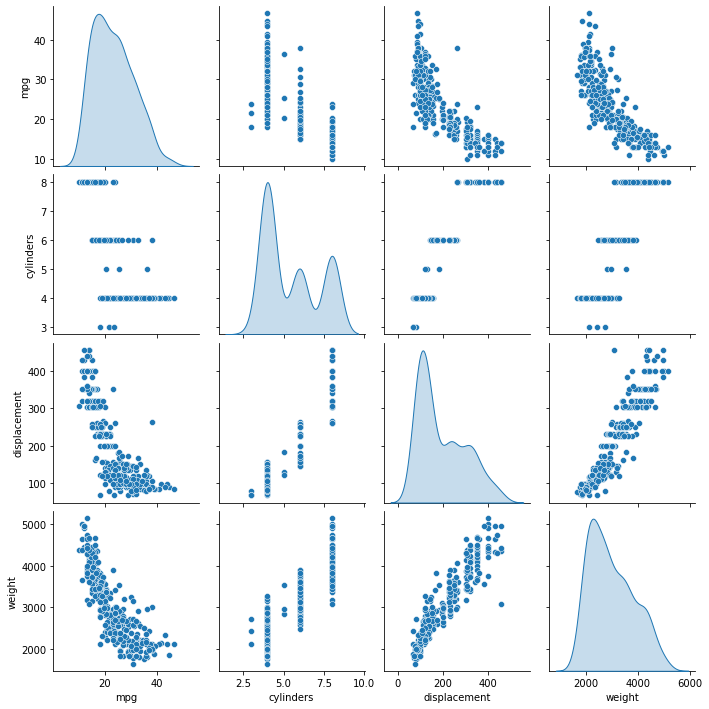

In [8]:
sns.pairplot(train_dataset[['mpg', 'cylinders', 'displacement', 'weight']],
             diag_kind='kde');

In [9]:
train_dataset.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,europe,japan,usa
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,23.310510,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089,0.178344,0.197452,0.624204
std,7.728652,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642,0.383413,0.398712,0.485101
min,10.000000,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.000000,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000,0.000000,0.000000,0.000000
50%,22.000000,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,28.950000,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('mpg')
test_labels = test_features.pop('mpg')

In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
normalizer.mean.numpy() # as above

array([   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
          0.178,    0.197,    0.624], dtype=float32)

In [12]:
first = np.array(train_features[:1]) # first record
with np.printoptions(precision=2, suppress=True):
    print('First record:', first)
    print('Normalized:', normalizer(first).numpy())

First record: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]
Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear Regression
### Single Variable
Predict MPG from HP alone

In [13]:
hp = np.array(train_features.horsepower)
hp_nmz = preprocessing.Normalization(input_shape=[1,])
hp_nmz.adapt(hp)

In [14]:
hp_mod = Sequential([hp_nmz, Dense(units=1)])
hp_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [15]:
# currently untrained, but...
hp_mod.predict(hp[:10])

array([[-0.678],
       [-0.383],
       [ 1.252],
       [-0.951],
       [-0.86 ],
       [-0.338],
       [-1.019],
       [-0.86 ],
       [-0.224],
       [-0.383]], dtype=float32)

In [16]:
ETA = 0.1
hp_mod.compile(optimizer=Adam(learning_rate=ETA), 
               loss='mean_absolute_error')

In [17]:
%%time

EPOCHS = 100
history = hp_mod.fit(train_features.horsepower,
                     train_labels,
                     epochs=EPOCHS,
                     verbose=0,
                     validation_split=0.2)

CPU times: user 4.69 s, sys: 441 ms, total: 5.13 s
Wall time: 4.77 s


In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.805819,4.164075,95
96,3.806710,4.192735,96
97,3.803774,4.193271,97
98,3.806292,4.184915,98
99,3.805451,4.197017,99


In [19]:
def plot_loss(hist):
    plt.plot(hist.loss, 'k-', label='loss')
    plt.plot(hist.val_loss, 'r-', label='val loss')
    plt.legend()

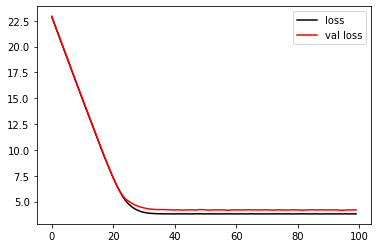

In [20]:
plot_loss(hist)

In [21]:
test_results = {}
test_results['hp_mod'] = hp_mod.evaluate(
    test_features.horsepower, test_labels, verbose=0)

In [22]:
x = tf.linspace(0., 250, 251)
y = hp_mod.predict(x)

In [23]:
def plot_pred(x, pred):
    plt.scatter(
        train_features.horsepower, train_labels, label='data', alpha=0.6)
    plt.plot(x, y, color='k', label='predictions')
    plt.xlabel('HP')
    plt.ylabel('MPG')

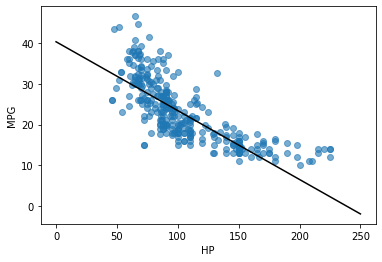

In [24]:
plot_pred(x, y)

### Multiple Predictors

In [25]:
lin_mod = Sequential([normalizer, Dense(units=1)])

In [26]:
lin_mod.predict(train_features[:10])

array([[-0.253],
       [ 1.455],
       [-1.467],
       [ 1.409],
       [-0.016],
       [ 0.559],
       [-0.002],
       [ 4.351],
       [-0.288],
       [-1.344]], dtype=float32)

In [27]:
lin_mod.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.382],
       [-0.577],
       [-0.214],
       [ 0.771],
       [ 0.322],
       [ 0.759],
       [ 0.605],
       [-0.64 ],
       [-0.085]], dtype=float32)>

In [28]:
lin_mod.compile(optimizer=Adam(learning_rate=ETA),
                loss='mean_absolute_error')

In [29]:
%%time

history = lin_mod.fit(train_features, # all cols being fed in here
                      train_labels,
                      epochs=EPOCHS,
                      verbose=0,
                      validation_split=0.2)

CPU times: user 4.24 s, sys: 256 ms, total: 4.49 s
Wall time: 4.08 s


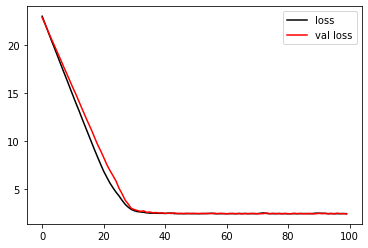

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_loss(hist)

In [31]:
test_results['lin_mod'] = lin_mod.evaluate(
    test_features, test_labels, verbose=0)
test_results

{'hp_mod': 3.63765549659729, 'lin_mod': 2.4831161499023438}

# DNN 

In [32]:
def build_and_compile_mod(norm):
    mod = Sequential([norm, 
                      Dense(64, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(1)])
    mod.compile(loss='mean_absolute_error',
                optimizer=Adam(ETA))
    return mod

In [34]:
dnn_hp_mod = build_and_compile_mod(hp_nmz)
dnn_hp_mod.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


### Single Predictor

In [42]:
history = dnn_hp_mod.fit(train_features['horsepower'],
                         train_labels,
                         validation_split=0.2,
                         verbose=0,
                         epochs=200)

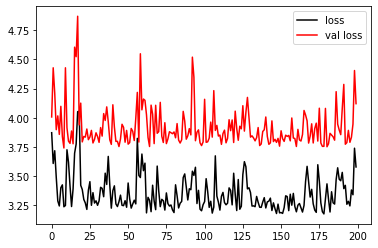

In [43]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_loss(hist)

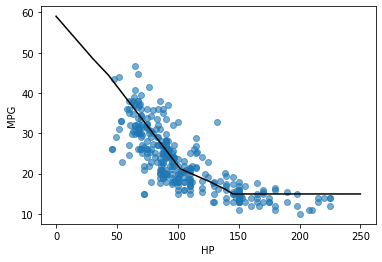

In [44]:
x = tf.linspace(0., 250, 251)
y = dnn_hp_mod.predict(x)
plot_pred(x, y)

In [45]:
test_results['dnn_hp_mod'] = dnn_hp_mod.evaluate(
    test_features['horsepower'], test_labels, verbose=0)

### Multiple Predictors

In [46]:
dnn_mod = build_and_compile_mod(normalizer)
dnn_mod.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [47]:
history = dnn_mod.fit(train_features,
                      train_labels,
                      validation_split=0.2,
                      verbose=0,
                      epochs=200)

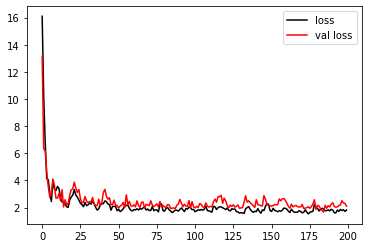

In [48]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_loss(hist)

In [50]:
test_results['dnn_mod'] = dnn_mod.evaluate(
    test_features, test_labels, verbose=0)

In [52]:
res = pd.DataFrame(test_results, index=['Mean Abs. Err']).T
res.sort_values(['Mean Abs. Err'])

,Mean Abs. Err
dnn_mod,1.873238
lin_mod,2.483116
dnn_hp_mod,3.050386
hp_mod,3.637655


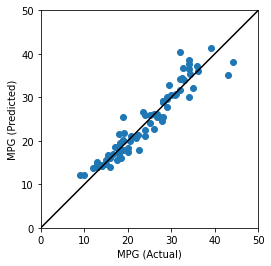

In [56]:
test_preds = dnn_mod.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_preds)
plt.xlabel('MPG (Actual)')
plt.ylabel('MPG (Predicted)')
lim = [0, 50]
plt.xlim(lim)
plt.ylim(lim)
plt.plot(lim, lim, 'k-');

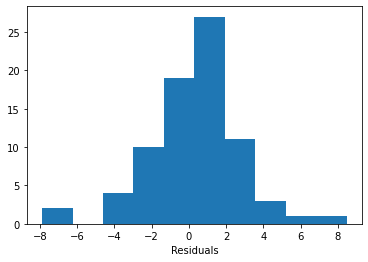

In [57]:
err = test_preds - test_labels
plt.hist(err)
plt.xlabel('Residuals');

In [ ]:
#dnn_mod.save('dnn_model')
#reloaded = tf.keras.models.load_model('dnn_model')
#test_results['reloaded'] = reloaded.evaluate(
#    test_features, test_labels, verbose=0)